In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
import pyross
import matplotlib.pyplot as plt
from scipy.io import loadmat
np.set_printoptions(precision=2)
plt.rcParams.update({'font.size': 26})

In [3]:
# get population in 4 age-groups: 0-20,20-40,40-60,60-80
M0=16;   Ni0 = pyross.utils.getPopulation("India", M0)
M=4; Ni=np.zeros(M)
for i in range(M):
    Ni[i] = np.sum(Ni0[i*4:(i+1)*4])
N = np.sum(Ni) 

# get contact matrix for M=4
CH0, CW0, CS0, CO0 = pyross.contactMatrix.India()
CH, CW, CS, CO = pyross.utils.get_summed_CM(CH0, CW0, CS0, CO0, M, M0, Ni, Ni0)

In [4]:
def get_data(contactMatrix, x0):
    M = 8
    beta  = 0.02           # probability of infection on contact 
    gIa   = 1./14            # removal rate of asymptomatic infectives 
    gE    = 1/4.72          # removal rate of exposeds
    gIs   = 1./14            # removal rate of symptomatic infectives 
    alpha = 0.              # asymptomatic fraction
    fsa   = 1               # suppresion of contact by symptomatics

    parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,'gE':gE,'fsa':fsa}
    model = pyross.deterministic.SEIR(parameters, M, Ni1)


    # start simulation
    Tf, Nf = 200, 200; 
    data = model.simulator(x0, contactMatrix, Tf, Nf)
    return model.Is(data)

[[14.3   4.35  1.95  0.37  0.    0.    0.    0.  ]
 [ 4.38  8.04  3.1   0.34  0.    0.    0.    0.  ]
 [ 3.23  4.26  3.41  0.34  0.    0.    0.    0.  ]
 [ 1.68  2.03  1.33  0.44  0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.   14.3   4.35  1.95  0.37]
 [ 0.    0.    0.    0.    4.38  8.04  3.1   0.34]
 [ 0.    0.    0.    0.    3.23  4.26  3.41  0.34]
 [ 0.    0.    0.    0.    1.68  2.03  1.33  0.44]]


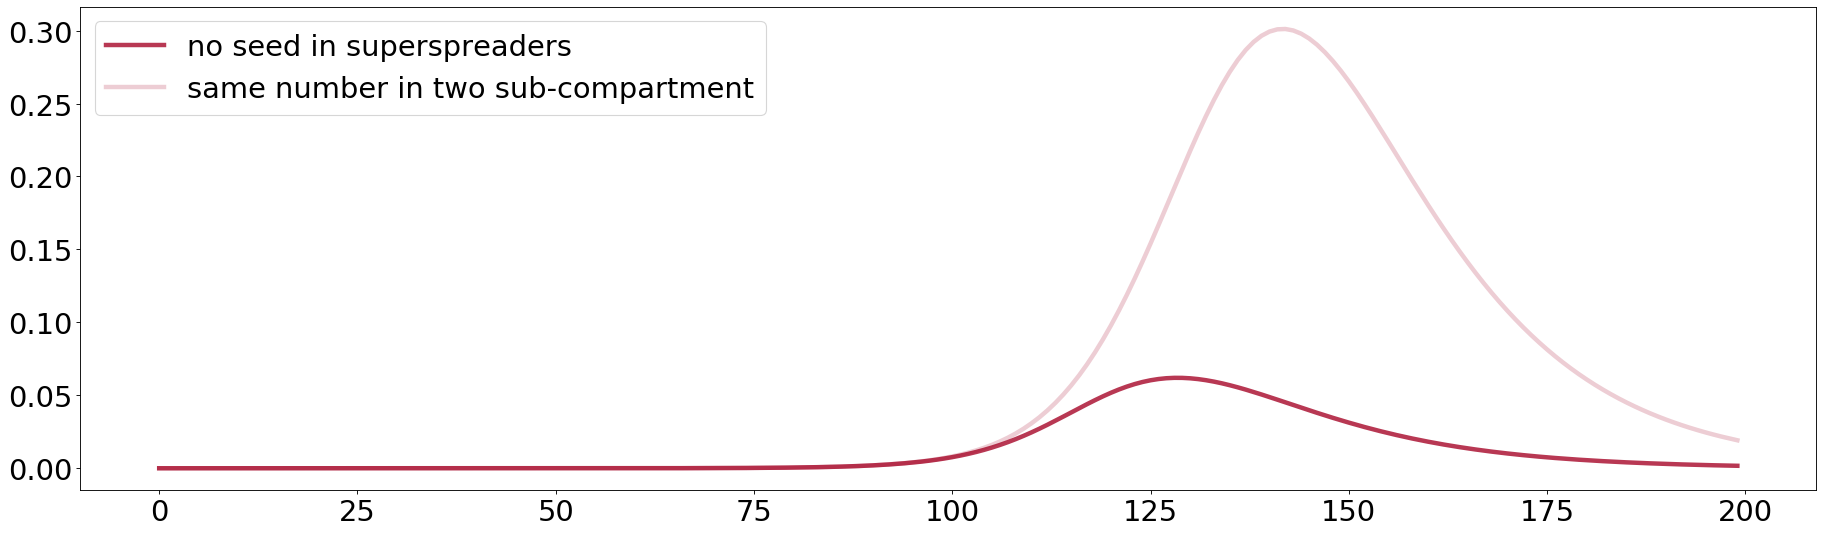

In [5]:
# get new population for two kind of spreaders
rN=0.2; brN=1-rN
rC=0; M=8
Ni1 = np.zeros(M);  Ni1[0:4] = rN*Ni;   Ni1[4:8] = brN*Ni;

CMS = np.zeros((M, M))
CMS[0:4,0:4] = CH + CW + CS + CO  
CMS[4:8,0:4] = (CO)*rC/(rN)  
CMS[0:4,4:8] = (CO)*rC/(brN)  
CMS[4:8,4:8] = (CH + CW + CS + CO)  
def contactMatrix(t):    return CMS
print(CMS)

# initial conditions    
Is_0 = np.zeros((M));  Is_0[0:4]=2; 
E_0  = np.zeros((M)); E_0[0:4]=4;  
x0 = np.concatenate(( Ni1-(Is_0 + E_0), E_0, Is_0*0, Is_0))
Is1 = get_data(contactMatrix, x0)
 
Is_0 = np.zeros((M));  Is_0[0:8]=1; 
E_0  = np.zeros((M));  E_0[0:8]=2;  
x0 = np.concatenate(( Ni1-(Is_0 + E_0), E_0, Is_0*0, Is_0))
Is2 = get_data(contactMatrix, x0)


fig = plt.figure(num=None, figsize=(28, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(np.sum(Is1, axis=1)/N, '-', lw=4, color='#A60628', label='no seed in superspreaders', alpha=0.8); 
plt.plot(np.sum(Is2, axis=1)/N, '-', lw=4, color='#A60628', label='same number in two sub-compartment', alpha=0.2); 
plt.legend()

We can see that initial condition makes a difference. Also if there are infected people in each group and $r^C=0$, implies that the dynamics is same as it would have been without the partionting since two compartment values add-up!

In [6]:
# get new population for two kind of spreaders
rN=0.2; brN=1-rN
rC=0.1; M=8

Ni1 = np.zeros(M);  Ni1[0:4] = rN*Ni;   Ni1[4:8] = brN*Ni;

CMS = np.zeros((M, M))
CMS[0:4,0:4] = CH + CW + CS + CO  
CMS[4:8,0:4] = (CO)*rC/(rN)  
CMS[0:4,4:8] = (CO)*rC/(brN)  
CMS[4:8,4:8] = (CH + CW + CS + CO)  
def contactMatrix(t):    return CMS
print(CMS)

# initial conditions    
Is_0 = np.zeros((M));  Is_0[0:4]=2; 
E_0  = np.zeros((M)); E_0[0:4]=4;  
x0 = np.concatenate(( Ni1-(Is_0 + E_0), E_0, Is_0*0, Is_0))
IsC2 = get_data(contactMatrix, x0)

[[14.3   4.35  1.95  0.37  0.85  0.28  0.12  0.03]
 [ 4.38  8.04  3.1   0.34  0.21  0.52  0.12  0.02]
 [ 3.23  4.26  3.41  0.34  0.07  0.16  0.1   0.02]
 [ 1.68  2.03  1.33  0.44  0.02  0.07  0.05  0.03]
 [ 3.4   1.11  0.47  0.11 14.3   4.35  1.95  0.37]
 [ 0.85  2.1   0.49  0.07  4.38  8.04  3.1   0.34]
 [ 0.27  0.62  0.39  0.07  3.23  4.26  3.41  0.34]
 [ 0.09  0.28  0.2   0.11  1.68  2.03  1.33  0.44]]


In [7]:
# get new population for two kind of spreaders
rN=0.2; brN=1-rN
rC=1; M=8

Ni1 = np.zeros(M);  Ni1[0:4] = rN*Ni;   Ni1[4:8] = brN*Ni;

CMS = np.zeros((M, M))
CMS[0:4,0:4] = CH + CW + CS + CO  
CMS[4:8,0:4] = (CO)*rC/(rN)  
CMS[0:4,4:8] = (CO)*rC/(brN)  
CMS[4:8,4:8] = (CH + CW + CS + CO)  
def contactMatrix(t):    return CMS
print(CMS)

# initial conditions    
Is_0 = np.zeros((M));  Is_0[0:4]=2; 
E_0  = np.zeros((M)); E_0[0:4]=4;  
x0 = np.concatenate(( Ni1-(Is_0 + E_0), E_0, Is_0*0, Is_0))
IsC3 = get_data(contactMatrix, x0)

[[14.3   4.35  1.95  0.37  8.5   2.78  1.17  0.26]
 [ 4.38  8.04  3.1   0.34  2.14  5.25  1.22  0.18]
 [ 3.23  4.26  3.41  0.34  0.67  1.55  0.98  0.18]
 [ 1.68  2.03  1.33  0.44  0.24  0.71  0.51  0.27]
 [34.   11.12  4.67  1.05 14.3   4.35  1.95  0.37]
 [ 8.55 20.99  4.88  0.73  4.38  8.04  3.1   0.34]
 [ 2.7   6.21  3.9   0.73  3.23  4.26  3.41  0.34]
 [ 0.94  2.83  2.03  1.09  1.68  2.03  1.33  0.44]]


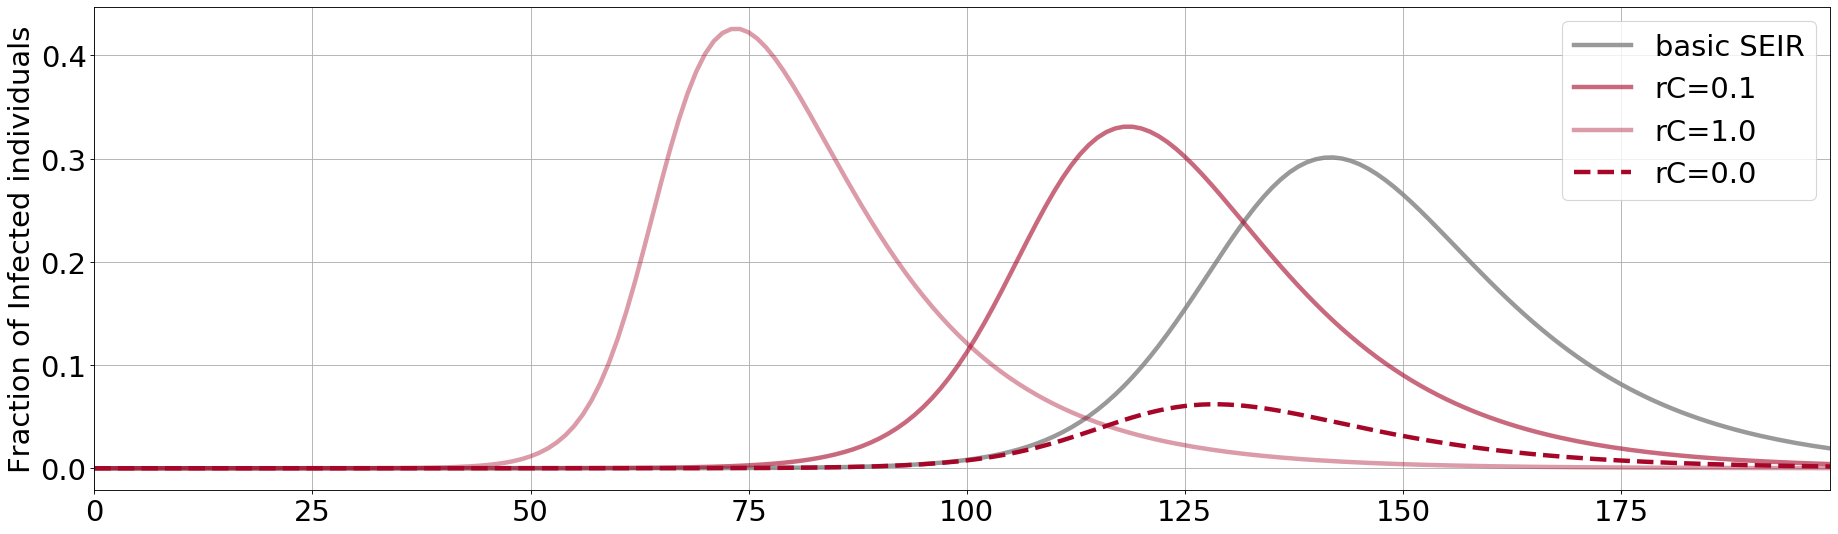

In [9]:
fig = plt.figure(num=None, figsize=(28, 8), dpi=80, facecolor='w', edgecolor='k')
 
plt.plot(np.sum(Is2, axis=1)/N, '-', lw=4, color='gray', label='basic SEIR', alpha=0.8)
plt.plot(np.sum(IsC2, axis=1)/N, '-', lw=4, color='#A60628', label='rC=0.1', alpha=0.6)
plt.plot(np.sum(IsC3, axis=1)/N, '-', lw=4, color='#A60628', label='rC=1.0', alpha=0.4)
plt.plot(np.sum(Is1, axis=1)/N, '--', lw=4, color='#A60628', label='rC=0.0', alpha=1)


plt.legend(fontsize=26, loc='upper right'); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Fraction of Infected individuals');


The initial condition is chosen such that infection is only seeded in in superspreader class. If the two classes do not talk, then the infection is only confined to the superspreader class, else it runs to the whole population...